# Instalación de las librerías

In [1]:
!pip install ultralytics
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Carga de librerías

In [2]:
import os
import random

from ultralytics import YOLO
import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import yaml

# Descarga dataset

In [3]:
# Download data from repository and unzip
%cd /content
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.001 -O trafic_data.zip.001
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.002 -O trafic_data.zip.002
!7z x -y -sdel trafic_data.zip.001
!rm trafic_data.zip.* -f

/content
--2024-04-15 18:49:53--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘trafic_data.zip.001’

trafic_data.zip.001 100%[===================>] 100.00M   218MB/s    in 0.5s    

2024-04-15 18:49:54 (218 MB/s) - ‘trafic_data.zip.001’ saved [104857600/104857600]

--2024-04-15 18:49:54--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.

# Descarga del modelo

In [ ]:


# Download the model and unzip
%cd /content
# !wget https://github.com/Laboratorios-2-MIT-MC/IA-Ciber/blob/PFinal-Felix/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x_blanco.zip.001 -O yolov8x_blanco.zip.001
# !wget https://github.com/Laboratorios-2-MIT-MC/IA-Ciber/blob/PFinal-Felix/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x_blanco.zip.002 -O yolov8x_blanco.zip.002
!wget https://github.com/Laboratorios-2-MIT-MC/IA-Ciber/blob/P3-Felix/Pr%C3%A1cticas/Proyecto%20Final/Modelo/best.pt

# !7z x -y -sdel yolov8x_blanco.zip.001
# !rm yolov8x.zip.* -f


# Exploración del dataset

In [5]:
# Path to files and labels
train_images = "/content/trafic_data/train/images"
train_labels = "/content/trafic_data/train/labels"

valid_images = "/content/trafic_data/train/images"
valid_labels = "/content/trafic_data/train/labels"

In [6]:
def loadLabels(image_file, image_labels):
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(image_labels, label_file)

    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    return labels

def plotObjectDetections(ax, image, labels):
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

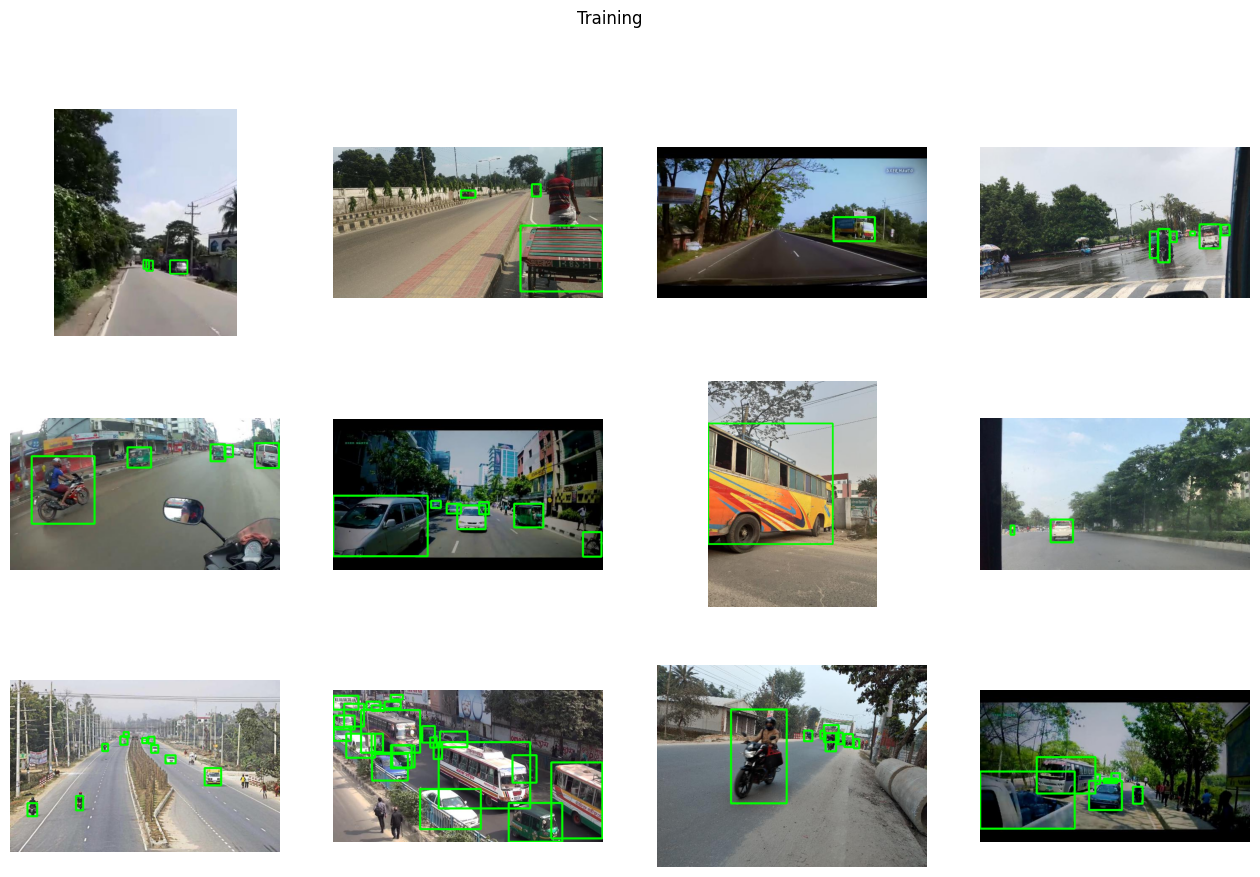

In [7]:
# List of all the training images
image_files = os.listdir(train_images)

# Choose 12 random image files from the list
random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = loadLabels(image_file, train_labels)

    # Plot object detections
    plotObjectDetections(axs[row, col], image, labels)

plt.suptitle("Training")
plt.show()

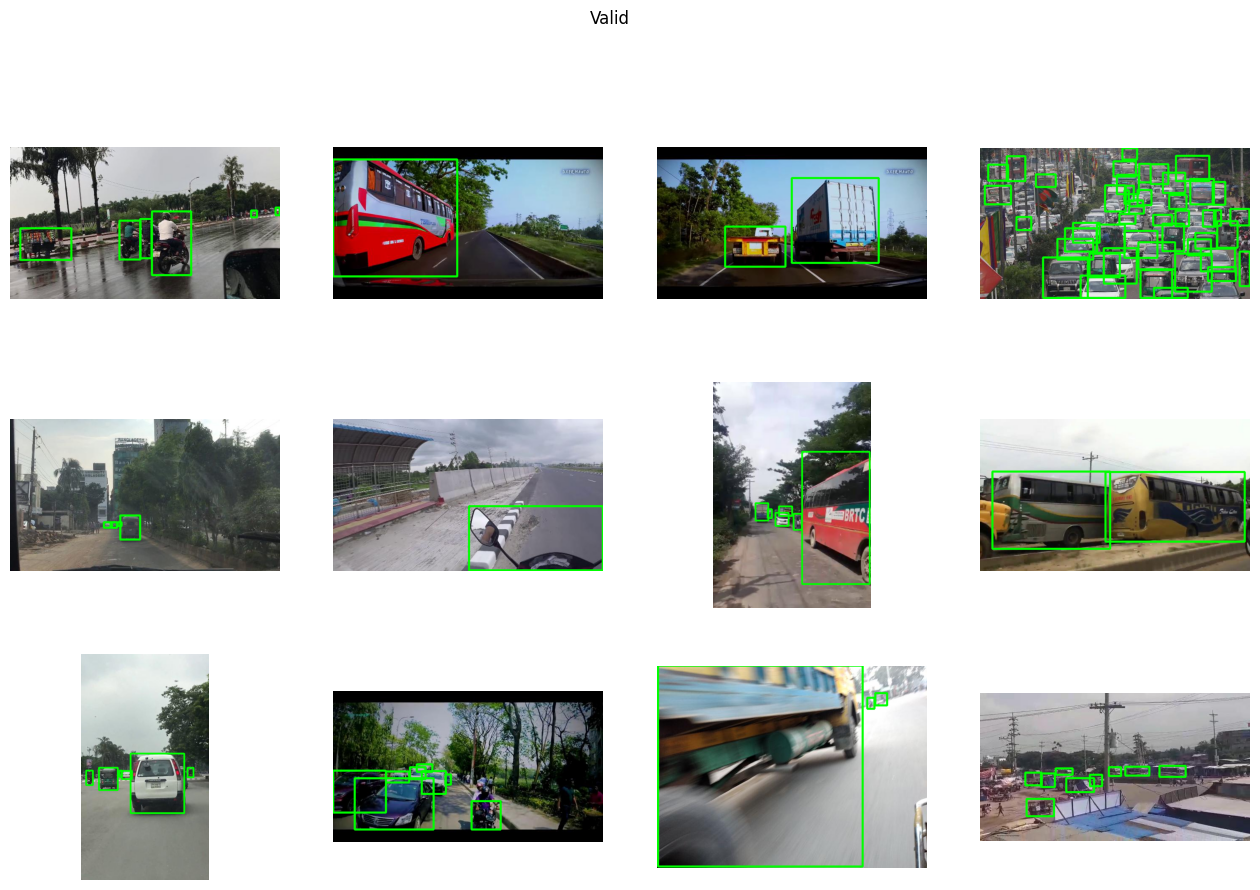

In [8]:
# List of all the valid images
image_files = os.listdir(valid_images)

# Choose 12 random image files from the list
random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    # Load the image
    image_path = os.path.join(valid_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = loadLabels(image_file, valid_labels)

    # Plot object detections
    plotObjectDetections(axs[row, col], image, labels)

plt.suptitle("Valid")
plt.show()

In [9]:
# Class names found on the Dataset
with open('/content/trafic_data/data_1.yaml', 'r') as f:
    data_yaml = yaml.load(f, Loader=yaml.FullLoader)

data_yaml["names"]

['ambulance',
 'army vehicle',
 'auto rickshaw',
 'bicycle',
 'bus',
 'car',
 'garbagevan',
 'human hauler',
 'minibus',
 'minivan',
 'motorbike',
 'pickup',
 'policecar',
 'rickshaw',
 'scooter',
 'suv',
 'taxi',
 'three wheelers -CNG-',
 'truck',
 'van',
 'wheelbarrow']

# Comprobación del rendimiento del modelo

In [10]:
# Carga de modelo y entrenamiento
# model = YOLO('yolov8x.pt')

model = YOLO()

model.train(data = '/content/trafic_data/data_1.yaml',
            device = '0',
            epochs = 20,
            seed = 42,
            batch = 8,
            workers = 4)


100%|██████████| 6.23M/6.23M [00:00<00:00, 72.8MB/s]


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [11]:
metrics = model.val(data = '/content/trafic_data/data_1.yaml', device='0')

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 0
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [ ]:
model.export()

In [20]:
import torch
model = torch.load("/content/best.pt")

model = YOLO(model)

TypeError: expected str, bytes or os.PathLike object, not dict

TypeError: 'dict' object is not callable

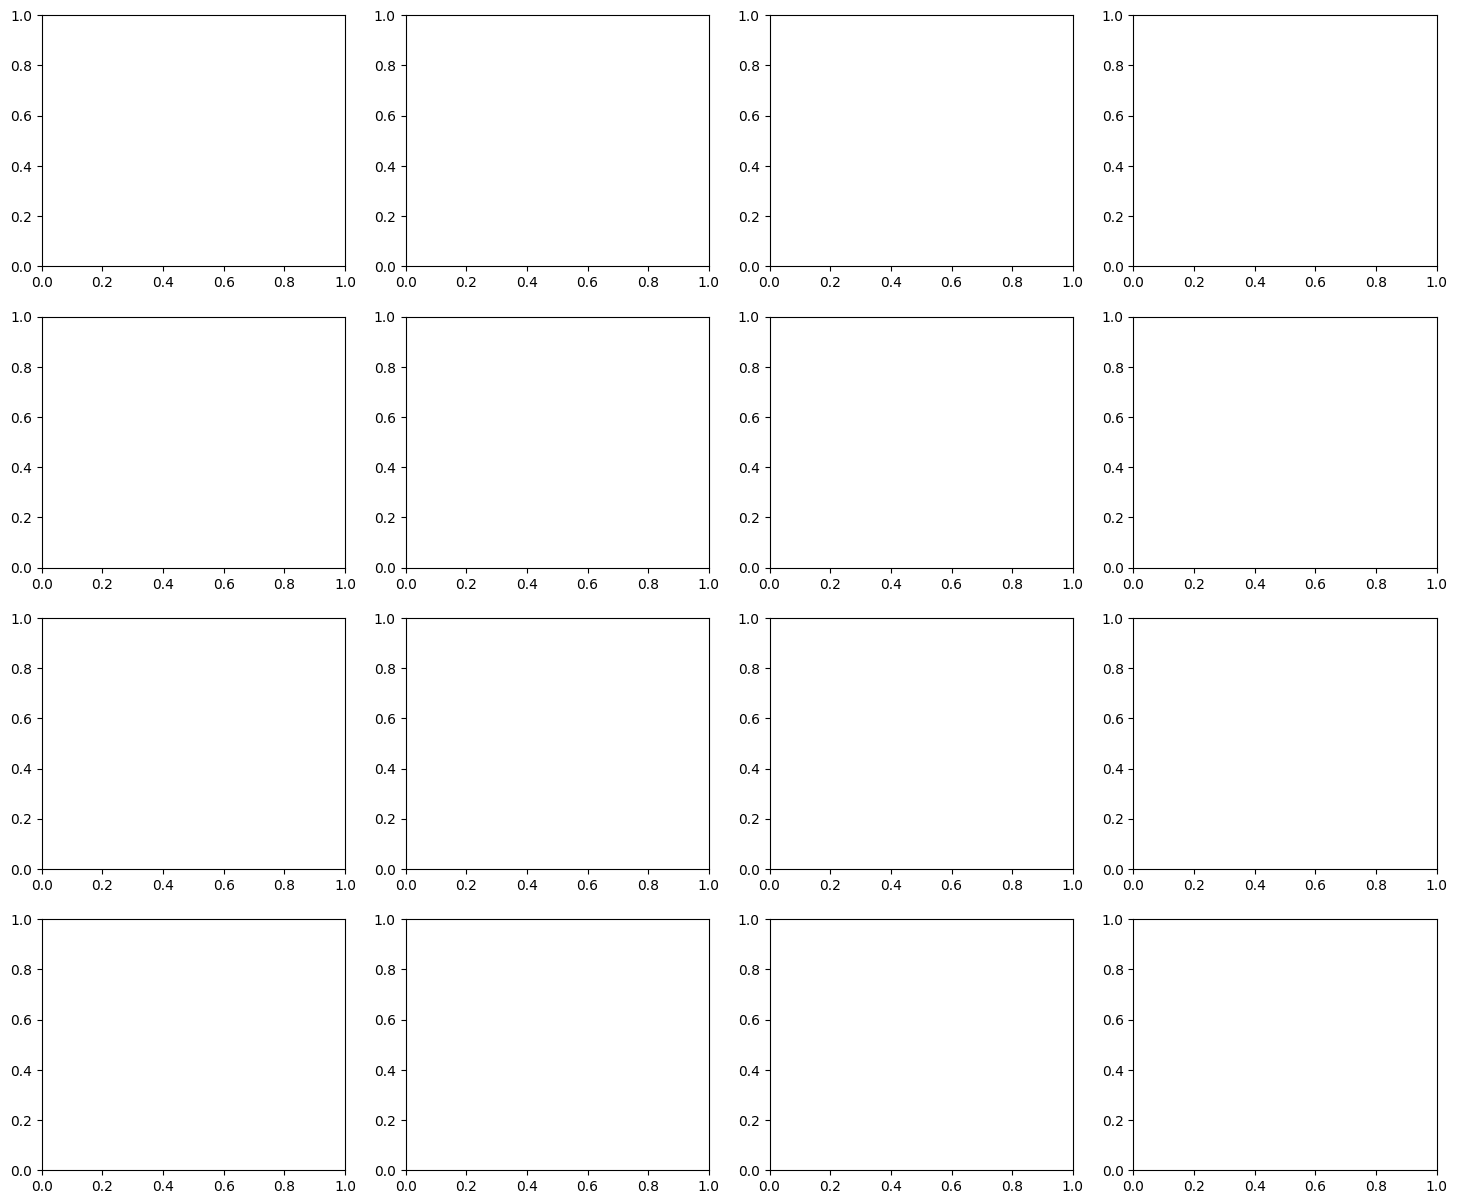

In [19]:
def ship_detect(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img

custom_image_dir = '/content/trafic_data/valid/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = ship_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Explicación del tipo de ataque

# Preparar el ataque

In [16]:
# Imports
# from torchvision import models
# import torch
# import cv2
# import numpy as np
# from scipy.optimize import differential_evolution
# import torch.nn as nn
# from torch.autograd import Variable
# import argparse


# Variables
pixels = 3
iterations = 600
population_size = 10

# Realizamos el ataque

In [17]:
def nothing(x):
    pass

image_path = '/content/trafic_data/valid/images'

# load image and reshape to (3, 224, 224) and RGB (not BGR)
# preprocess as described here: http://pytorch.org/docs/master/torchvision/models.html
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (32, 32))
img = orig.copy()
shape = orig.shape



def preprocess(img):
    img = img.astype(np.float32)
    img /= 255.0
    img = img.transpose(2, 0, 1)
    return img

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def perturb(x):
    adv_img = img.copy()

    # calculate pixel locations and values
    pixs = np.array(np.split(x, len(x)/5)).astype(int)
    loc = (pixs[:, 0], pixs[:,1])
    val = pixs[:, 2:]
    adv_img[loc] = val

    return adv_img

def optimize(x):
    adv_img = perturb(x)

    inp = Variable(torch.from_numpy(preprocess(adv_img)).float().unsqueeze(0))
    out = model(inp)
    prob = softmax(out.data.numpy()[0])

    return prob[pred_orig]

pred_adv = 0
prob_adv = 0
def callback(x, convergence):
    global pred_adv, prob_adv
    adv_img = perturb(x)

    inp = Variable(torch.from_numpy(preprocess(adv_img)).float().unsqueeze(0))
    out = model(inp)
    prob = softmax(out.data.numpy()[0])

    pred_adv = np.argmax(prob)
    prob_adv = prob[pred_adv]
    if pred_adv != pred_orig and prob_adv >= 0.9:
        print('Attack successful..')
        print('Prob [%s]: %f' %(data_yaml["names"][pred_adv], prob_adv))
        print()
        return True
    else:
        print('Prob [%s]: %f' %(data_yaml["names"][pred_orig], prob[pred_orig]))


def scale(x, scale=5):
    return cv2.resize(x, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)


while True:
    bounds = [(0, shape[0]-1), (0, shape[1]), (0, 255), (0, 255), (0, 255)] * pixels
    result = differential_evolution(optimize, bounds, maxiter=iterations, popsize=population_size, tol=1e-5, callback=callback)

    adv_img = perturb(result.x)
    inp = Variable(torch.from_numpy(preprocess(adv_img)).float().unsqueeze(0))
    out = model(inp)
    prob = softmax(out.data.numpy()[0])
    print('Prob [%s]: %f --> Prob[%s]: %f' %(data_yaml["names"][pred_orig], prob_orig[pred_orig], data_yaml["names"][pred_adv], prob_adv))

    cv2.imshow('adversarial image', scale(adv_img[..., ::-1]))

    key = 0
    while True:
        print("Press 'esc' to exit, 'space' to re-run..", end="\r")
        key = cv2.waitKey(100) & 0xFF
        if key == 27:
            break
        elif key == ord('s'):
            cv2.imwrite('adv_img.png', scale(adv_img[..., ::-1]))
        elif key == 32:
            break
    if key == 27:
        break
cv2.destroyAllWindows()


/content
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


val: Scanning /content/trafic_data/valid/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/trafic_data/valid/images/Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: WARNING ⚠️ /content/trafic_data/valid/images/Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


                   all        300       2568    0.00709     0.0629    0.00419    0.00327
            motorcycle        300         32    0.00516      0.906    0.00683    0.00293
              airplane        300        425     0.0833    0.00235     0.0463     0.0417
                   bus        300        842     0.0144     0.0451    0.00757    0.00485
                  boat        300          2          0          0          0          0
         traffic light        300        110          0          0          0          0
          fire hydrant        300        335          0          0          0          0
             stop sign        300        142          0          0          0          0
         parking meter        300          1          0          0          0          0
                 bench        300        192     0.0105     0.0521    0.00632    0.00276
                  bird        300          1          0          0          0          0
                   ca

NameError: name 'differential_evolution' is not defined

# Análisis de los resultados del ataque

# Aplicaciones en la vida real